## Business Undestanding


### Bestimmung der Problemstellung: 
Hier wird an den Anwender die Anforderung gestellt, das Data Mining Projekt betriebswirtschaftlich auszurichten. Dabei werden die operationalen und betriebswirtschaftlichen Zielkriterien formuliert.
>Bei der vorliegenden Projektaufgabe gilt es, drei Prognosemodelle zu erstellen, um auf Basis der vorliegenden Daten zu den Brunnen bestimmen zu können, welche der gegebenen Brunnen funktionieren, welche nicht und welche repariert werden müssen. Dabei soll anhand der ML-Pipeline, aufbauend auf dem CRISP-DM Modell, vorgegangen werden und die Güte der einzelnen Modelle anhand der Area-Under-Curve (AUC) auf den Testdaten qualifiziert werden. 



### Bestimmung analytischer Ziele:
Ausgehend von der zuvor bestimmten Problemdefinition müssen dazu die erforderlichen Datenanalyseaufgaben ermittelt werden. Zudem müssen die Erfolgskriterien für das Data Mining-Projekt bestimmt werden.
>Prognosemodell welche Brunnen funktionieren und welche nicht

>Prognosemodell für die Brunnen die repariert werden müssen 

>Prognosemodell, das zwischen allen drei Klassen unterscheidet

#### Vorgehen:
<ol>
    <li> Datenanalyse
    <li> Feature Engineering
    <li> Model Selection
    <li> Erstellung + Hyperparameter-Tuning von drei binären Modellen
    <li> Zusammenführung in ein Multilabel-Model
    <li> Evaluation der Güte der Models
</ol>

## Data Understanding


### Daten sammeln: 
Hier werden die benötigten Daten für die Analyse beschaffen und, wenn erforderlich, in bereits bestehende Datenmengen integriert. Dabei sollten Probleme, die bei der Datenbeschaffung auftreten, stets dokumentiert werden, um mögliche Diskrepanzen bei einem Folgeprojekt in der Zukunft zu vermeiden.

Im folgenden werden alle vorhandenen Daten der Trainings- und Testdatensätze aufgelistet:

>amount_tsh - Total static head (amount water available to waterpoint)

>date_recorded - The date the row was entered

>funder - Who funded the well

>gps_height - Altitude of the well

>installer - Organization that installed the well

>longitude - GPS coordinate

>latitude - GPS coordinate 

>wpt_name - Name of the waterpoint if there is one

>num_private -

>basin - Geographic water basin

>subvillage - Geographic location

>region - Geographic location

>region_code - Geographic location (coded)

>district_code - Geographic location (coded)

>lga - Geographic location

>ward - Geographic location

>population - Population around the well

>public_meeting - True/False

>recorded_by - Group entering this row of data

>scheme_management - Who operates the waterpoint

>scheme_name - Who operates the waterpoint

>permit - If the waterpoint is permitted

>construction_year - Year the waterpoint was constructed

>extraction_type - The kind of extraction the waterpoint uses

>extraction_type_group - The kind of extraction the waterpoint uses

>extraction_type_class - The kind of extraction the waterpoint uses

>management - How the waterpoint is managed

>management_group - How the waterpoint is managed

>payment - What the water costs

>payment_type - What the water costs

>water_quality - The quality of the water

>quality_group - The quality of the water

>quantity - The quantity of water

>quantity_group - The quantity of water

>source - The source of the water

>source_type - The source of the water

>source_class - The source of the water 


> Bei der Beschreibung der einzelnen Merkmale, und somit der einzelnen Spalten, des Datensatzes fällt auf, dass die Beschreibungen der einzelnen Merkmale öfters doppelt vorkommen. Zum Beispiel haben die Merkmale quantity und quantity_group genau dieselbe Beschreibung. Daraus lässt sich schließen, dass zweiteres Merkmal eventuell "nur" eine Gruppierung des ersteren ist. 

> Diese Merkmale könnten eventuell in der Data Preparation dann entfernt werden.

In [150]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from utils import Dataset
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product

from utils import one_vs_all, get_prob_and_pred

from sklearn.model_selection import GridSearchCV

In [151]:
# read the csv files / datasets into a pandas dataframe
train_data = pd.read_csv("pump_train.csv")
test_data = pd.read_csv("pump_test.csv")

### Daten beschreiben: 
In diesem Schritt gilt es, ein allgemeines Verständnis für die Daten zu erlangen. Zudem werden die Eigenschaften der Daten beschrieben, wie z.B. Quantität der Daten, Formateigenschaften, Anzahl der Einträge und Felder sowie Eigenschaften der Felder. Die entscheidende Frage ist, ob die vorliegenden Daten der Datenanalyse genügen, um das Projekt erfolgreich abzuschließen.


In [152]:
# using different functions of pandas to describe the dataset better
train_data.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [153]:
print("Train data rows, columns:",train_data.shape)
print("Test data rows, columns:", test_data.shape)

Train data rows, columns: (50490, 41)
Test data rows, columns: (8910, 41)


In [154]:
train_data.head(10)

id  amount_tsh date_recorded                          funder  \
0  12237        30.0    2013-01-23          Government Of Tanzania   
1  24566         0.0    2013-02-07              Private Individual   
2  20536         0.0    2011-07-15                          Sawaka   
3  30633       200.0    2011-03-25          Government Of Tanzania   
4   2993         0.0    2011-02-17           African Muslim Agency   
5  41668         0.0    2013-02-15                      Nyitamboka   
6  61839         0.0    2013-02-09                           Rwssp   
7  62441         0.0    2011-02-21          Government Of Tanzania   
8  53492         0.0    2012-10-18  Member Of Perliament Ahmed Ali   
9  54314         0.0    2011-08-01      The Desk And Chair Foundat   

   gps_height                       installer  longitude   latitude  \
0         107                District Council  39.360880 -10.295705   
1           0                          Edward  32.644074  -3.859265   
2           0                             DWE  30.999792  -1.721771   
3        2142                           Commu  34.060324  -9.335288   
4         290                District Council  38.862874  -7.165410   
5        1229                      Nyitamboka  34.349079  -1.630274   
6           0                             DWE  32.586745  -3.815508   
7          75                           Centr  39.010886  -7.615327   
8           0  Member of Perliament Ahmed Ali  33.165581  -3.796312   
9           0      The desk and chair foundat  33.326639  -3.027799   

                    wpt_name  num_private  ... water_quality quality_group  \
0             Zahanati Membe            0  ...          soft          good   
1              Kwa Mama Wini            0  ...          soft          good   
2                   Kwasimon            0  ...          soft          good   
3                       none            0  ...          soft          good   
4                  Msikitini            0  ...          soft          good   
5       Nyitamboka Kitanyita            0  ...         salty         salty   
6                      Idete            0  ...         milky         milky   
7  Nyambili Primary School 2            0  ...          soft          good   
8            Kwa Hima Ganaye            0  ...          soft          good   
9                    Nguruko            0  ...          soft          good   

       quantity  quantity_group        source   source_type source_class  \
0        enough          enough         river    river/lake      surface   
1  insufficient    insufficient  shallow well  shallow well  groundwater   
2        enough          enough  shallow well  shallow well  groundwater   
3        enough          enough        spring        spring  groundwater   
4           dry             dry   machine dbh      borehole  groundwater   
5        enough          enough  shallow well  shallow well  groundwater   
6           dry             dry  shallow well  shallow well  groundwater   
7        enough          enough        spring        spring  groundwater   
8  insufficient    insufficient  shallow well  shallow well  groundwater   
9        enough          enough  shallow well  shallow well  groundwater   

               waterpoint_type waterpoint_type_group    status_group  
0  communal standpipe multiple    communal standpipe      functional  
1                        other                 other      functional  
2                        other                 other  non functional  
3           communal standpipe    communal standpipe      functional  
4                    hand pump             hand pump  non functional  
5                    hand pump             hand pump      functional  
6                        other                 other  non functional  
7           communal standpipe    communal standpipe  non functional  
8                    hand pump             hand pump      functional  
9                    hand pump             hand

In [155]:
train_data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50490 entries, 0 to 50489
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     50490 non-null  int64  
 1   amount_tsh             50490 non-null  float64
 2   date_recorded          50490 non-null  object 
 3   funder                 47396 non-null  object 
 4   gps_height             50490 non-null  int64  
 5   installer              47380 non-null  object 
 6   longitude              50490 non-null  float64
 7   latitude               50490 non-null  float64
 8   wpt_name               50490 non-null  object 
 9   num_private            50490 non-null  int64  
 10  basin                  50490 non-null  object 
 11  subvillage             50175 non-null  object 
 12  region                 50490 non-null  object 
 13  region_code            50490 non-null  int64  
 14  district_code          50490 non-null  int64  
 15  lg

In [156]:
train_data.describe().T

count          mean           std        min  \
id                 50490.0  37113.857695  21447.241039   0.000000   
amount_tsh         50490.0    319.158123   2987.517185   0.000000   
gps_height         50490.0    669.714280    693.123330 -90.000000   
longitude          50490.0     34.078591      6.553382   0.000000   
latitude           50490.0     -5.708336      2.943806 -11.648378   
num_private        50490.0      0.459497     10.413455   0.000000   
region_code        50490.0     15.280511     17.550035   1.000000   
district_code      50490.0      5.641731      9.668596   0.000000   
population         50490.0    180.913389    479.854870   0.000000   
construction_year  50490.0   1301.724520    951.258506   0.000000   

                            25%           50%           75%           max  
id                 18517.250000  37027.500000  55636.750000  7.424700e+04  
amount_tsh             0.000000      0.000000     20.000000  3.500000e+05  
gps_height             0.000000    371.000000   1322.000000  2.770000e+03  
longitude             33.084409     34.906548     37.178899  4.034519e+01  
latitude              -8.541643     -5.019807     -3.327550 -2.000000e-08  
num_private            0.000000      0.000000      0.000000  1.402000e+03  
region_code            5.000000     12.000000     17.000000  9.900000e+01  
district_code          2.000000      3.000000      5.000000  8.000000e+01  
population             0.000000     25.000000    215.750000  3.050000e+04  
construction_year      0.000000   1986.000000   2004.000000  2.013000e+03

In [157]:
# checking how many different values are there in each column in percent %
(train_data.nunique()/len(train_data)*100).sort_values(ascending=False)

id                       100.000000
latitude                  96.882551
longitude                 96.878590
wpt_name                  64.151317
subvillage                35.203010
scheme_name                5.115865
gps_height                 4.771242
ward                       4.129531
installer                  3.889879
funder                     3.434343
population                 1.958804
date_recorded              0.689245
lga                        0.247574
amount_tsh                 0.186175
num_private                0.122797
construction_year          0.108932
region_code                0.053476
region                     0.041592
district_code              0.039612
extraction_type            0.035651
extraction_type_group      0.025748
management                 0.023767
scheme_management          0.023767
source                     0.019806
basin                      0.017825
water_quality              0.015845
extraction_type_class      0.013864
payment                    0

In [158]:
(train_data.recorded_by=="GeoData Consultants Ltd").all() # shows that every value is the same

True

> Hieran ist zu erkennen, dass die Selektivität der Merkmale / Attribute im Datensatz variiert. Werte mit sehr hoher Selektivität und diskrete Werte könnten für das weitere Vorgehen Schwierigkeiten mit sich bringen. Beispielsweise sind die Werte der ID (100%) alle unique, im Gegensatz dazu ist 'recorded_by' (0,001981%) bei allen gleich.

> Allgemein geht aus der Analyse der Daten oben hervor, dass der Trainingsdatensatz aus 50940 Zeilen à 41 Spalten und der Testdatensatz aus 8910 Zeile à 41 Spalten besteht. Dabei sind die Datentypen des Datensatzes hauptsächlich int, float und object.

### Untersuchung der Daten: 
Zur Untersuchung der Daten werden erste Analysen mit den Daten betrieben. Ziel ist es dabei, die ersten Erkenntnisse und Hypothesen zu visualisieren.

In [159]:
# checking for null values in the data set in absolute numbers and percentage
null_columns = train_data.isnull().sum().sort_values(ascending=False)
pd.concat([null_columns[null_columns!=0],null_columns[null_columns!=0]/len(train_data)*100], axis=1, keys=['abs', '%'])

abs          %
scheme_name        23942  47.419291
scheme_management   3269   6.474549
installer           3110   6.159636
funder              3094   6.127946
public_meeting      2846   5.636760
permit              2591   5.131709
subvillage           315   0.623886

#### Untersuchung des Testdatensatzes auf fehlende Werte:

In [160]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8910 entries, 0 to 8909
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     8910 non-null   int64  
 1   amount_tsh             8910 non-null   float64
 2   date_recorded          8910 non-null   object 
 3   funder                 8369 non-null   object 
 4   gps_height             8910 non-null   int64  
 5   installer              8365 non-null   object 
 6   longitude              8910 non-null   float64
 7   latitude               8910 non-null   float64
 8   wpt_name               8910 non-null   object 
 9   num_private            8910 non-null   int64  
 10  basin                  8910 non-null   object 
 11  subvillage             8854 non-null   object 
 12  region                 8910 non-null   object 
 13  region_code            8910 non-null   int64  
 14  district_code          8910 non-null   int64  
 15  lga 

In [161]:
test_data.head()

id  amount_tsh date_recorded   funder  gps_height installer  longitude  \
0  69572      6000.0    2011-03-14    Roman        1390     Roman  34.938093   
1   8776         0.0    2013-03-06  Grumeti        1399   GRUMETI  34.698766   
2  49056         0.0    2011-02-20  Private          62   Private  39.209518   
3  58155         0.0    2011-09-04   Unicef        1656       DWE  34.569266   
4  34169         0.0    2011-07-22   Hesawa        1162       DWE  32.920154   

   latitude         wpt_name  num_private  ... water_quality quality_group  \
0 -9.856322             none            0  ...          soft          good   
1 -2.147466         Zahanati            0  ...          soft          good   
2 -7.034139    Mzee Hokororo            0  ...         salty         salty   
3 -9.085515  Kwa Rose Chaula            0  ...          soft          good   
4 -1.947868           Ngomee            0  ...         milky         milky   

       quantity  quantity_group                source           source_type  \
0        enough          enough                spring                spring   
1  insufficient    insufficient  rainwater harvesting  rainwater harvesting   
2        enough          enough           machine dbh              borehole   
3           dry             dry                 river            river/lake   
4  insufficient    insufficient                spring                spring   

  source_class     waterpoint_type waterpoint_type_group  \
0  groundwater  communal standpipe    communal standpipe   
1      surface  communal standpipe    communal standpipe   
2  groundwater               other                 other   
3      surface  communal standpipe    communal standpipe   
4  groundwater               other                 other   

              status_group  
0               functional  
1               functional  
2               functional  
3           non functional  
4  functional needs repair  

[5 rows x 41 columns]

In [162]:
null_columns = test_data.isnull().sum().sort_values(ascending=False)
pd.concat([null_columns[null_columns!=0],null_columns[null_columns!=0]/len(test_data)*100], axis=1, keys=['abs', '%'])

abs          %
scheme_name        4224  47.407407
scheme_management   608   6.823793
installer           545   6.116723
funder              541   6.071829
public_meeting      488   5.476992
permit              465   5.218855
subvillage           56   0.628507

> In den Spalten funder, installer, subvillage, public_meeting, scheme_management, scheme_name und permit existieren fehlende Werte. Dabei handelt es sich bei allen Spalten um den Datentyp object. Diese fehlende Werte müssen in der Data Preparation ihrem Datentyp entsprechend später bereinigt bzw. aufgefüllt werden.

> Die Verteilung der fehlenden Werte in den seperaten Test- und Trainingsdatensätzen ist sehr ähnlich, was dafür spricht, dass die Verteilung beider Datensätze einer Grundgesamtheit entsprechen.


Folgend wollen wir den Datensatz genauer visualisieren, das heißt wir wollen die Verteilung der einzelnen Merkmale und die Abhängigkeiten dieser untereinander genauer betrachten.

#### Histogramm der Merkmale

In [163]:
# defining colors for the plots
my_cmap = plt.get_cmap("Set2")

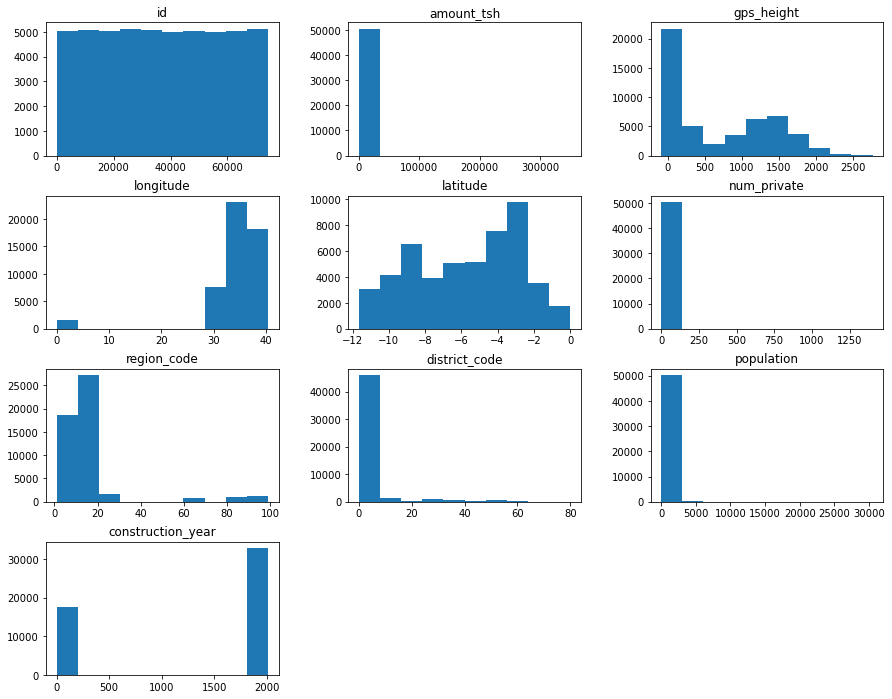

In [164]:
train_data.hist(bins=10,figsize=(15,12),grid=False);

> Im obigen Histogramm sind unterschiedliche Informationen zu den Datenpunkten abzulesen. Hierbei ist es ebenfalls möglich auf fehlende oder falsche Werte zu schließen. Bei der ID ist zu erkennen, dass es sich um eine fortlaufende Nummer handelt. Bei den Werten 'amount_tsh', 'num_private', 'district_code', 'population' sowie 'construction_year' ist die Hohe Anzahl im Nullwerte Bereich auffällig. 'latitude' und 'gps_height' sind beide über den Wertebereich verteilt aufgestellt.

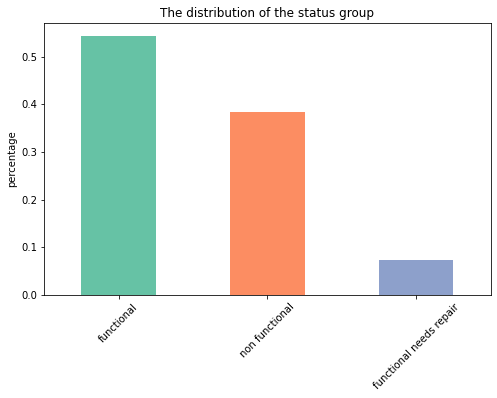

In [165]:
fig = plt.figure(figsize=(8,5))  
train_data.status_group.value_counts(normalize = "true").plot(kind="bar", title="The distribution of the status group", ylabel="percentage", color=my_cmap.colors)
plt.xticks(rotation=45);

In [166]:
number= sum(train_data[train_data.status_group == 'functional'].value_counts())
print("Es gibt im Datensatz insgesamt " + str(number) + " Brunnen, die funktionieren.")
number1= sum(train_data[train_data.status_group == 'non functional'].value_counts())
print("Es gibt im Datensatz insgesamt " + str(number1) + " Brunnen, die nicht funktionieren.")
number2= sum(train_data[train_data.status_group == 'functional needs repair'].value_counts())
print("Es gibt im Datensatz insgesamt " + str(number2) + " Brunnen, die repariert werden müssen.")

Es gibt im Datensatz insgesamt 13663 Brunnen, die funktionieren.
Es gibt im Datensatz insgesamt 8275 Brunnen, die nicht funktionieren.
Es gibt im Datensatz insgesamt 1712 Brunnen, die repariert werden müssen.


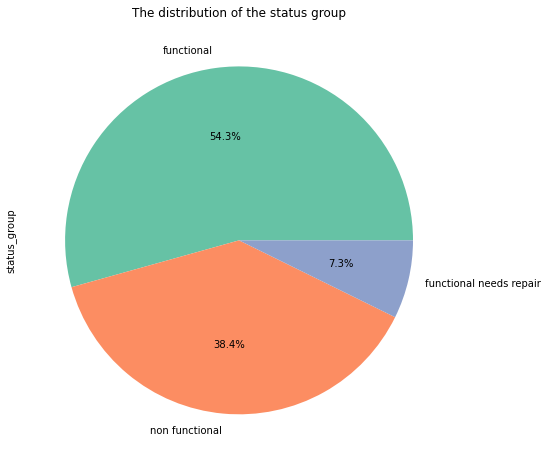

In [206]:
# making a pie chart
fig = plt.figure(figsize=(10,8)) 
train_data.status_group.value_counts(normalize = "true").plot(kind="pie", title="The distribution of the status group", autopct='%1.1f%%', colors=my_cmap.colors)
plt.xticks(rotation=45);

>Wie in beiden Grafiken zu erkennen ist, sind über 50% der Brunnen funktionsfähig. Nahezu 40% sind nicht funktionsfähig und etwas weniger als 10% müssen repariert werden. Die Verteilung zeigt auf, dass nur die Hälfte aller Brunnen einsatzbereit sind um die Anwohner mit Wasser zu versorgen.

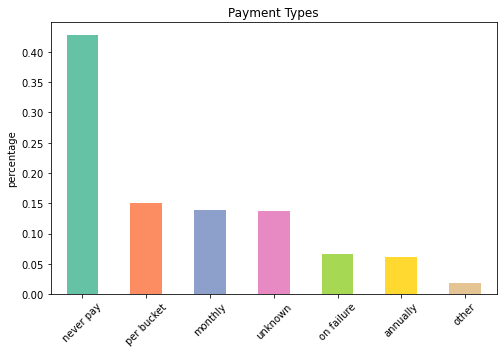

In [168]:
fig = plt.figure(figsize=(8,5))  
train_data.payment_type.value_counts(normalize = "true").plot(kind="bar", title="Payment Types", ylabel="percentage", color=my_cmap.colors)
plt.xticks(rotation=45);

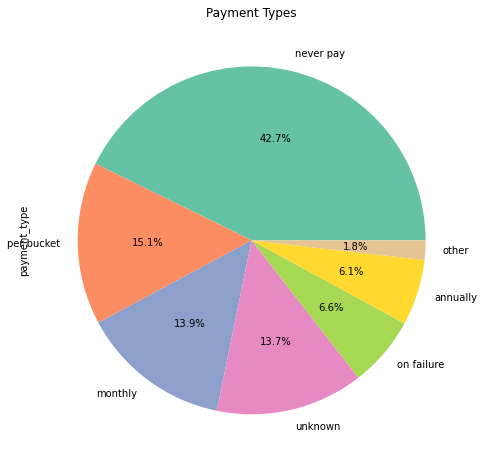

In [169]:
fig = plt.figure(figsize=(10,8))  
train_data.payment_type.value_counts(normalize = "true").plot(kind="pie", title="Payment Types", autopct='%1.1f%%', colors=my_cmap.colors)
plt.xticks(rotation=45);

>Beide Visualisierungen stellen die Zahlungsmethoden da. Auffällig ist, dass es sehr viele unterschiedliche Zahlungsmethoden sind. Dennoch wird der Großteil durch 'never pay' vertreten. Auf den Kontext bezogen könnte dies erklären, warum viele Brunnen nicht weiter repariert oder berücksichigt werden, da einfach kein Geld vorliegt.

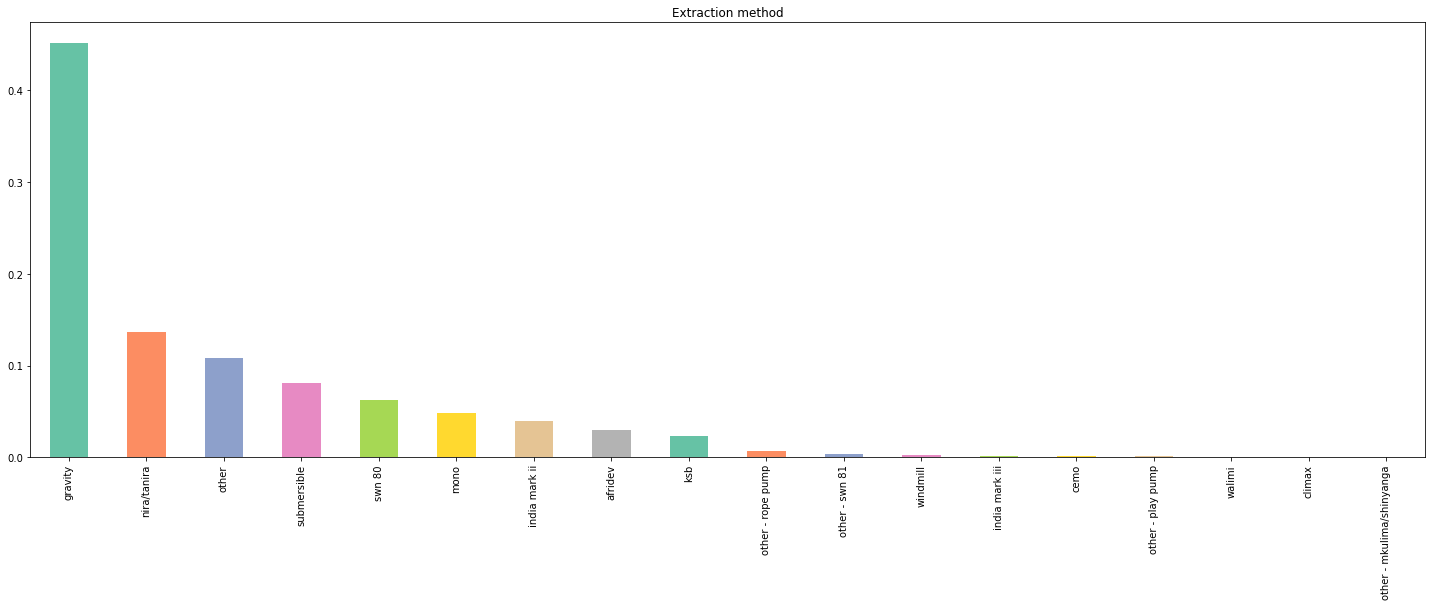

In [170]:
fig = plt.figure(figsize=(25,8))  
train_data.extraction_type.value_counts(normalize="True").plot(kind="bar", title="Extraction method", color=my_cmap.colors);

>Diese Grafik zeigt die Verteilung des Attributs 'extraction_type' auf. Dabei ist zu erkennen, dass die meisten Brunnen mit der Methode Gravity arbeiten, um an das Wasser zu gelangen. Auch ist auffällig, dass manche Extraction Types gar nicht genutzt werden, wie zum Beispiel walimi oder climax.

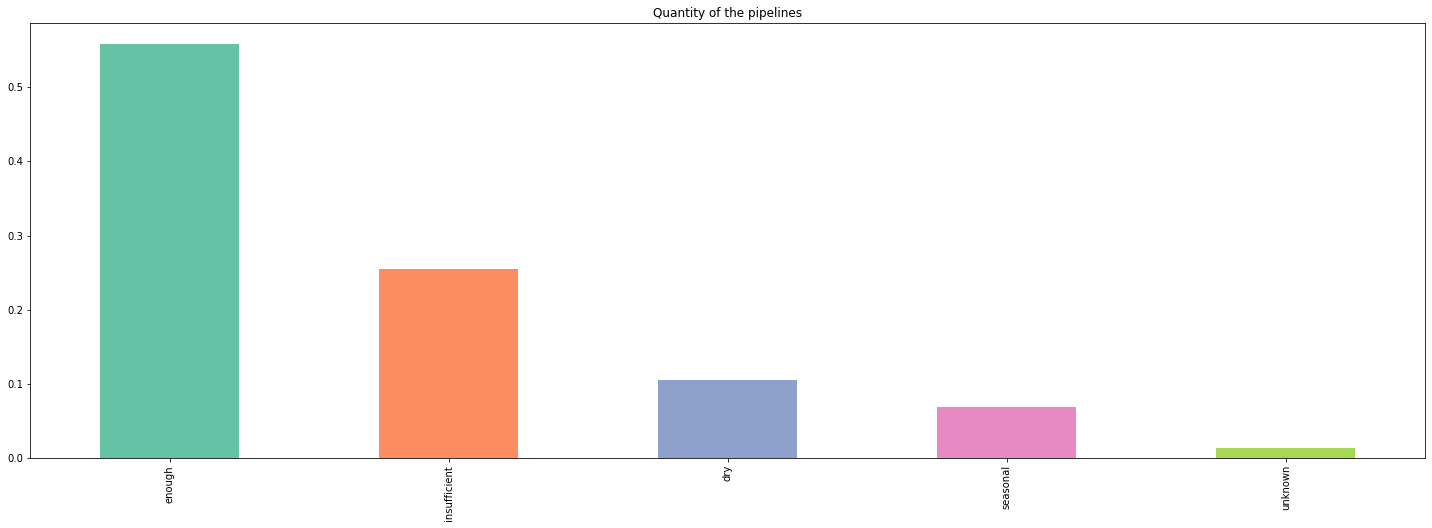

In [173]:
fig = plt.figure(figsize=(25,8))  
train_data.quantity.value_counts(normalize="True").plot(kind="bar", title="Quantity of the pipelines", color=my_cmap.colors);

> Die Grafik veranschaulicht den Status der jeweiligen Brunnen. Knapp 60% liefern genug Wasser. Etwa 25% sind insuffizient und knapp 12% sind trocken. Von weniger als 10% ist bekannt, dass die Funktionalität Saison bedingt und somit an die Regenzeit gebunden ist. Ebenfalls gibt es ein paar wenige Brunnen von denen keine Informationen vorliegen.

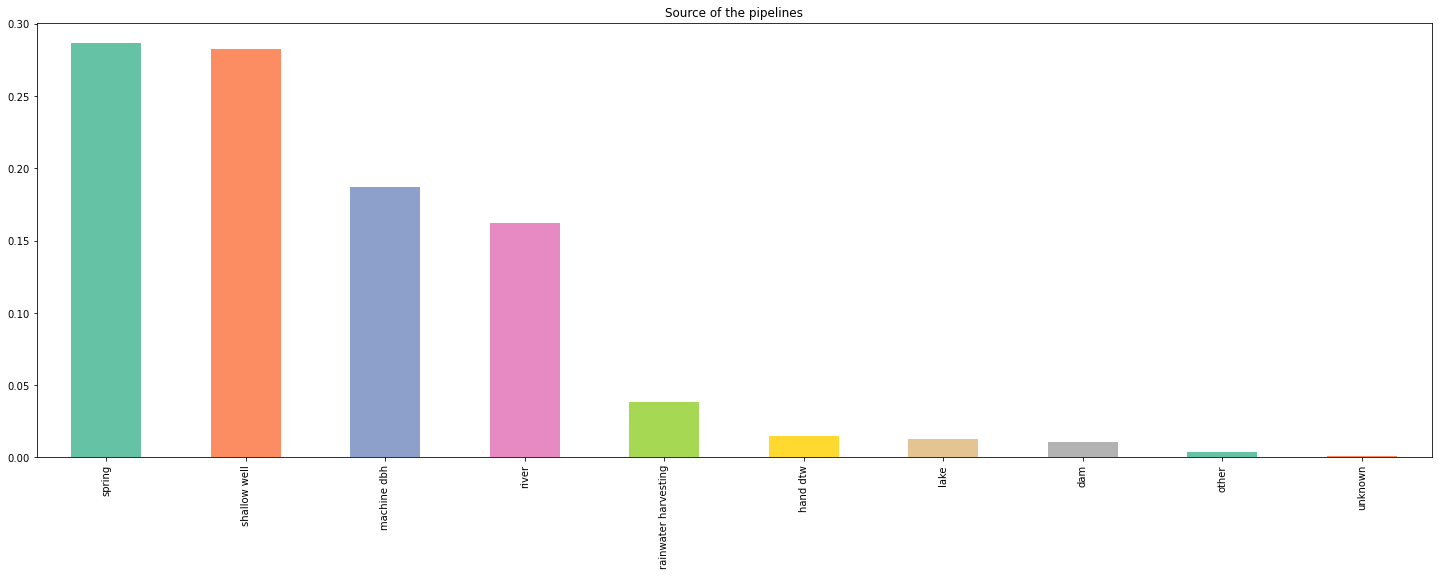

In [174]:
fig = plt.figure(figsize=(25,8))  
train_data.source.value_counts(normalize="True").plot(kind="bar", title="Source of the pipelines", color=my_cmap.colors);

>Die Brunnen beziehen sich auf unterschiedliche Quellen wie oben zu sehen ist. Vorreiter mit knapp 30% sind 'spring' und 'shallow well'. Dies zeigt den natürlichen Ursprung des Wassers.

#### Korrelations-Heatmap

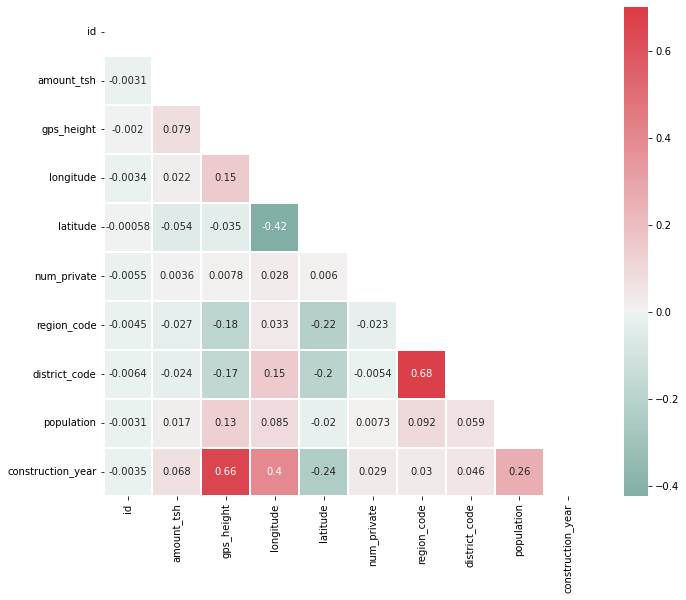

In [175]:
# Subset the dataset into all the numerical values
#numeric = train_data.select_dtypes(include=[np.number])

# Compete the correlation matrix
corr = train_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(7010, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0,
                     vmax=.7, linewidths=0.01, annot=True, square=True, ax=ax) #eventuell linewidths=.5,
plt.show();

>Die deutlichsten Korrelationen zeigen sich zwischen den Längen- und Breitengraden mit einem Wert von - 0.42, dem 'district_code' und 'region_code' mit einem Wert von 0.68 sowie zwischen dem 'gps_height' und dem 'construction_year' mit einem Wert von 0.66.

> Wichtig hierbei ist, dass alle Werte einen Einfluss auf einander haben und man auf Grund einer geringen Korrelation nicht sagen kann, das bestimmte Werte irrelevant sind.

> Die Korrelationen zwischen den numerischen Werten sagen momentan nicht besonders viel aus, da es hauptsächlich hohe Korrelationen zwischen den geographischen Merkmalen wie Longitude and Lattitude bspw. gibt

<img src="elevation_tanzania.jpeg" alt="Alternative text" />

In [217]:
print(f'{(train_data.gps_height==0).sum()/len(train_data)*100:.2f} % der Datenpunkte sind bei genau 0, was unrealistisch ist')

34.34 % der Datenpunkte sind bei genau 0, was unrealistisch ist


In [218]:
# daher zu nan setzen
train_data.loc[train_data["gps_height"]==0, "gps_height"] = np.nan

In [176]:
# converting 'date_recorded' to numerical values
dr = pd.to_datetime(train_data.date_recorded)
train_data["date_recorded"] = dr.dt.year + dr.dt.month/12

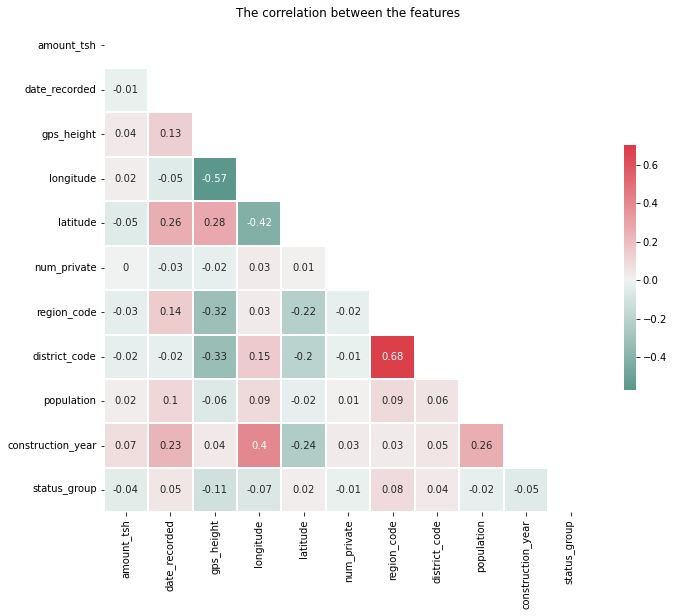

In [219]:
corr_matrix = train_data.copy()
# adding status_group to the correlation map
corr_matrix["status_group"] = corr_matrix["status_group"].map({"functional": 0, "non functional": 1, "functional needs repair": 2})
# show heatmap of correlations without id and hide the upper triangle
corr_matrix = corr_matrix.corr()
corr_matrix = corr_matrix.drop("id").drop("id", axis=1).round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(7010, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=0.7, center=0, annot=True,
            square=True, linewidths=.01, cbar_kws={"shrink": .5})
plt.title('The correlation between the features');

>Diese Heatmap zeigt nochmals eine andere Darstellungsmöglichkeit der Korrelation. Dabei wurden auch die Attribute 'date_recorded' und 'status_group' miteinbezogen, indem sie in numerische Werte umgewandelt wurden. Dadurch lassen sich weitere Korrelationen ablesen.

#### Verteilung des Merkmals status_group pro Region

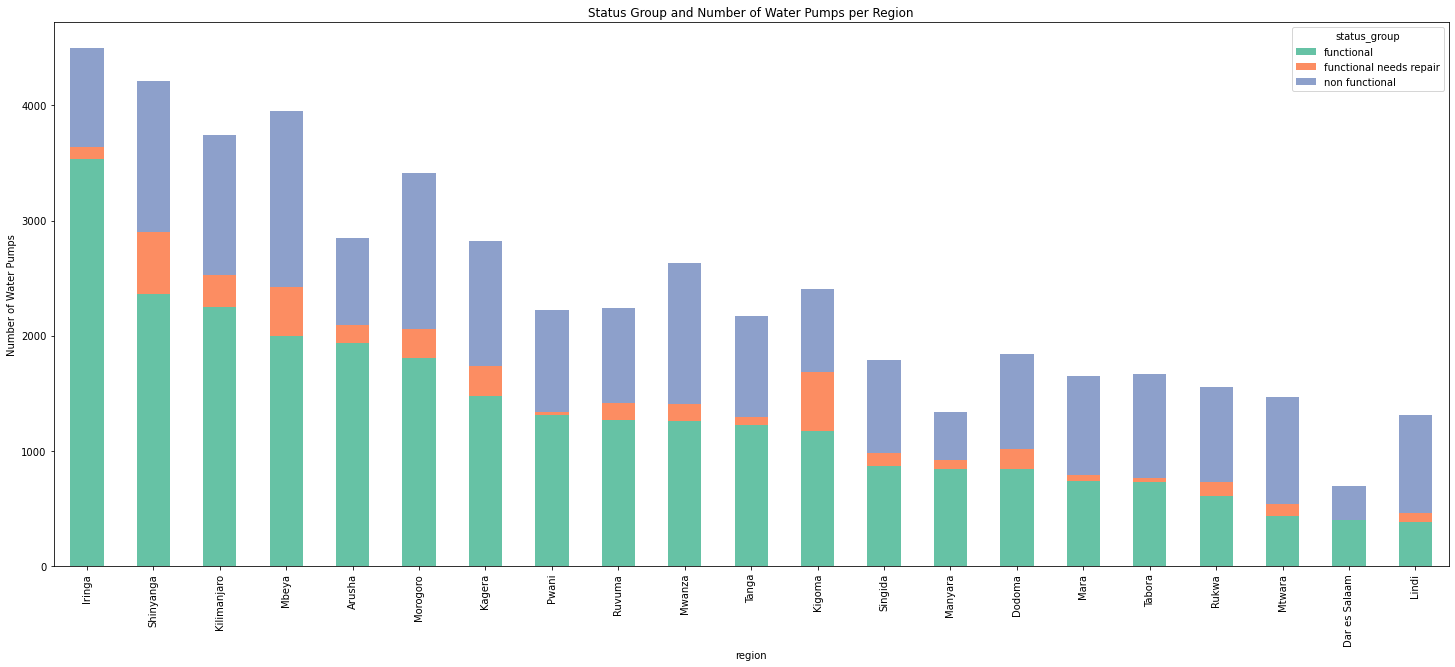

In [185]:
df_plot = train_data.groupby(['region', 'status_group']).size().reset_index().pivot(columns='status_group', index='region', values=0).sort_values('functional', ascending=False)
df_plot.plot(kind='bar', stacked=True, figsize=(25,10), title='Status Group and Number of Water Pumps per Region', ylabel='Number of Water Pumps', color=my_cmap.colors);

>Diese Grafik zeigt den Zusammenhang zwischen der Anzahl der bestehenden Brunnen je Region im Bezug zu deren Funktionalität. Allgemein lässt sich ungefähr sagen, dass etwa die Hälfte der Brunnen je Region nicht funktionsfähig ist. In Iringa befinden sich die meisten Brunnen, gefolgt von Shinyango und Mbeya. In Shinyango, Kigoma und Mbeya befinden sich auch die meisten Brunnen, die repariert werden sollten. Ebenfalls in Mbeya, Shinyanga, Morogoro und Kilimanjaro sind die meisten Brunnen, die nicht funktionsfähig sind. Es zeigt sich, dass desto mehr Brunnen in einer Region installiert sind, desto größer ist die Wahrscheinlichkeit, dass diese nicht funktionsfähig sind.

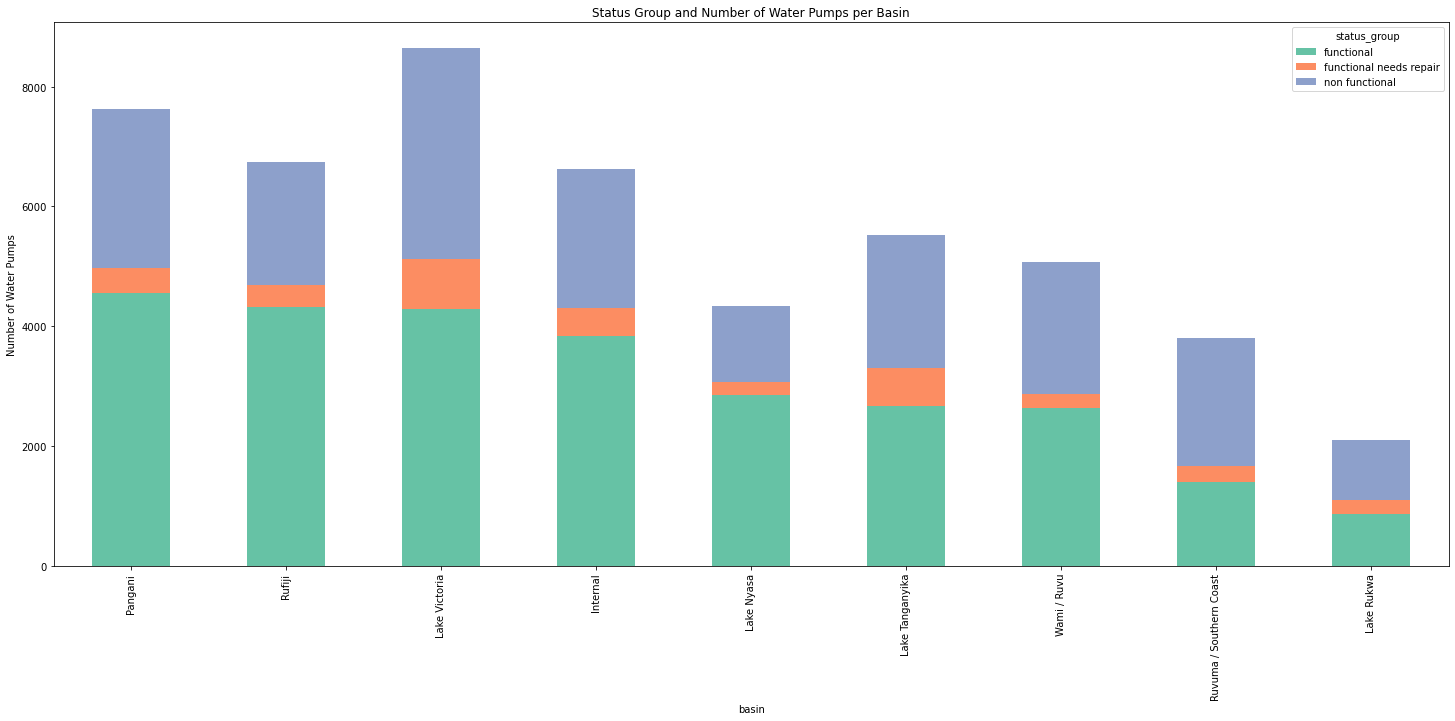

In [186]:
df_plot = train_data.groupby(['basin', 'status_group']).size().reset_index().pivot(columns='status_group', index='basin', values=0).sort_values('functional',ascending=False)
df_plot.plot(kind='bar', stacked=True, figsize=(25,10), title='Status Group and Number of Water Pumps per Basin', ylabel='Number of Water Pumps', color=my_cmap.colors);

>Dieses Diagramm zeigt die Verteilung des Attributes 'status_group' in Bezug auf die Quelle. Es fällt auf, dass 'Basin' nicht besonders viel Einfluss auf die 'status_group' hat.

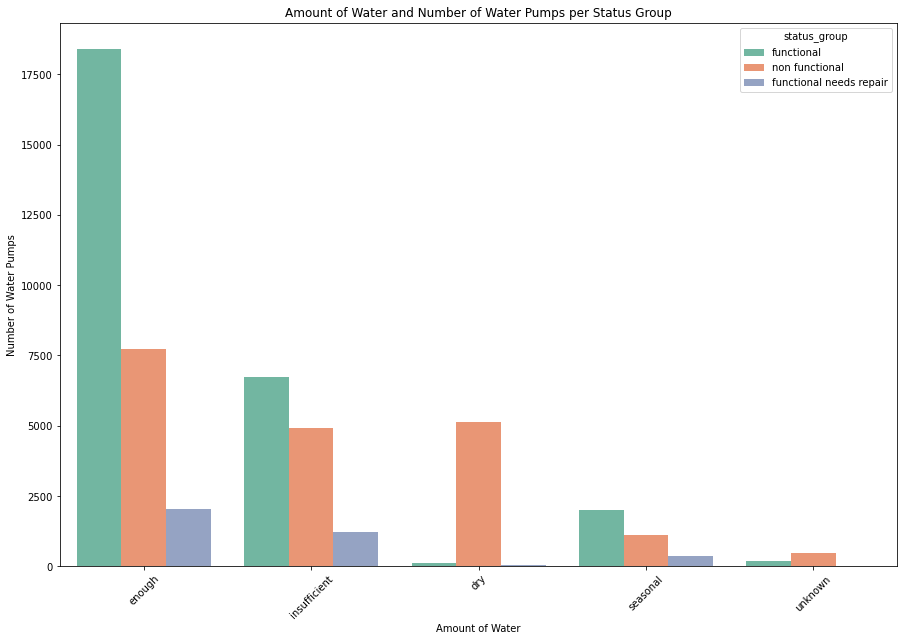

In [187]:
fig = plt.figure(figsize=(15,10))  
plot = sns.countplot(data=train_data, x='quantity', hue='status_group', palette="Set2")
plot.set(xlabel='Amount of Water', ylabel='Number of Water Pumps', title='Amount of Water and Number of Water Pumps per Status Group')
plt.xticks(rotation=45);

>Dieses Chart stellt die Beziehung zwischen der Funktionalität der Brunnen und des Wasservorkommens dar. In den Regionen, in denen genug Wasser vorhanden ist, befinden sich die meisten funktionsfähigen Brunnen. Etwas mehr als die Hälfte in diesem Gebiet ist nicht funktionsfähig. In Bereichen, in denen das Wasservorkommen insuffizient ist, ist die Verteilung von funktionsfähig und nicht funktionsfähig sehr ausgeglichen. In wasserlosen Gebieten ist kein Brunnen funktionsfähig. In Bereichen in denen es ein saisonales Wasservorkommen gibt, ist die Verteilung der Funktionalität ebenfalls ausgeglichen.


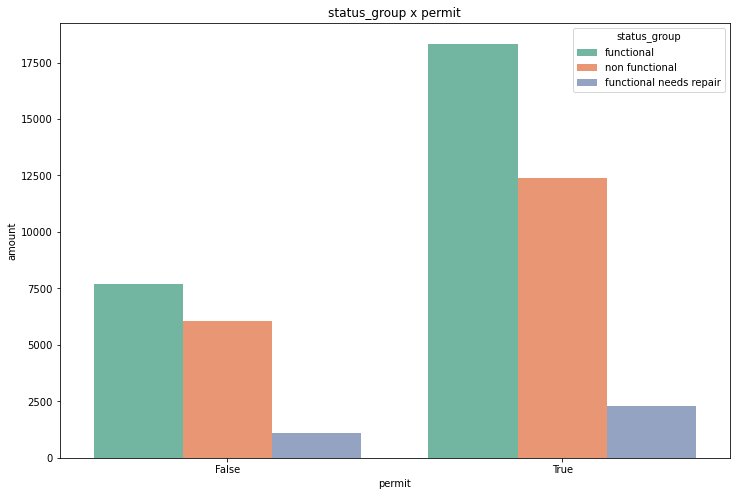

In [192]:
plt.figure(figsize=(12,8))
attrition_counts = (train_data.groupby(['permit'])['status_group']
                     .value_counts()
                     .rename('amount')
                     .reset_index()
                     .sort_values('permit'))
plt.title('status_group x permit')
sns.barplot(x="permit", y="amount", hue="status_group", data=attrition_counts, palette="Set2");

>Die Grafik verdeutlicht den Zusammenhang zwischen 'permit' und den 'status_group' Werten. Es zeigt sich, dass eine Kausalität nicht zu vermuten ist.
>Dieses Barchart verschafft einen Überblick über die rechtliche Sachlage. Knapp 70% sind genehmigte Brunnen. Etwas mehr als 30% jedoch nicht. Dies macht es schwierig, Wartungen und gute Bedingungen zu garantieren.

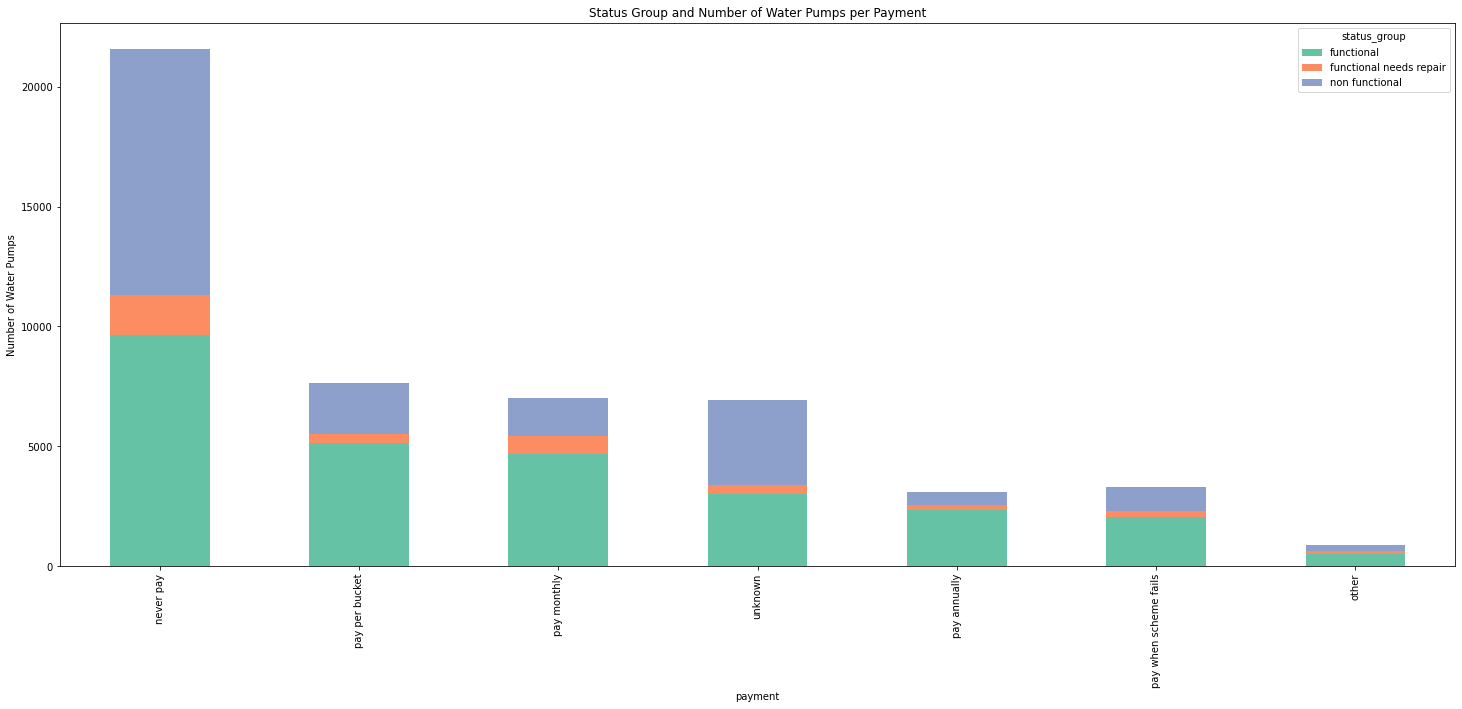

In [199]:
df_plot = train_data.groupby(['payment', 'status_group']).size().reset_index().pivot(columns='status_group', index='payment', values=0).sort_values('functional',ascending=False)
df_plot.plot(kind='bar', stacked=True, figsize=(25,10), title='Status Group and Number of Water Pumps per Payment', ylabel='Number of Water Pumps', color=my_cmap.colors);

>Schwierig zu interpretieren...

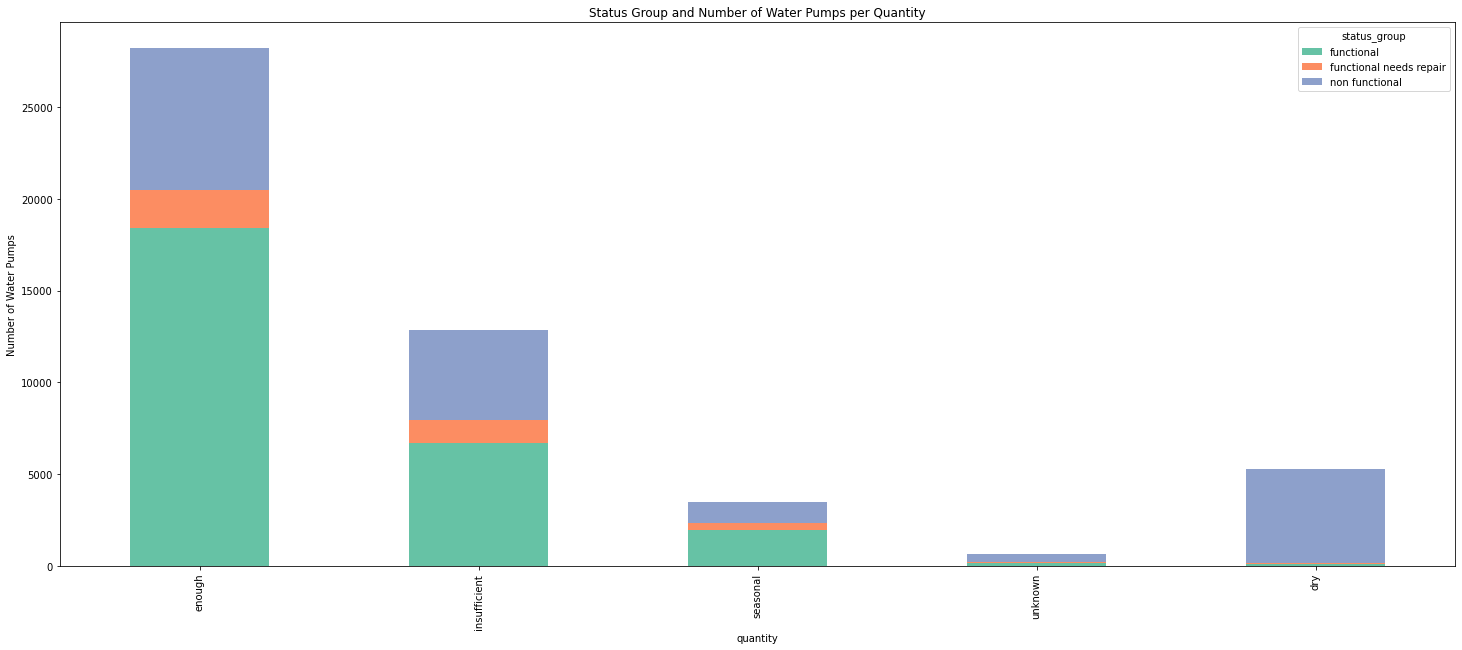

In [200]:
df_plot = train_data.groupby(['quantity', 'status_group']).size().reset_index().pivot(columns='status_group', index='quantity', values=0).sort_values('functional',ascending=False)
df_plot.plot(kind='bar', stacked=True, figsize=(25,10), title='Status Group and Number of Water Pumps per Quantity', ylabel='Number of Water Pumps', color=my_cmap.colors);

>Hatten wir das nicht schonmal?

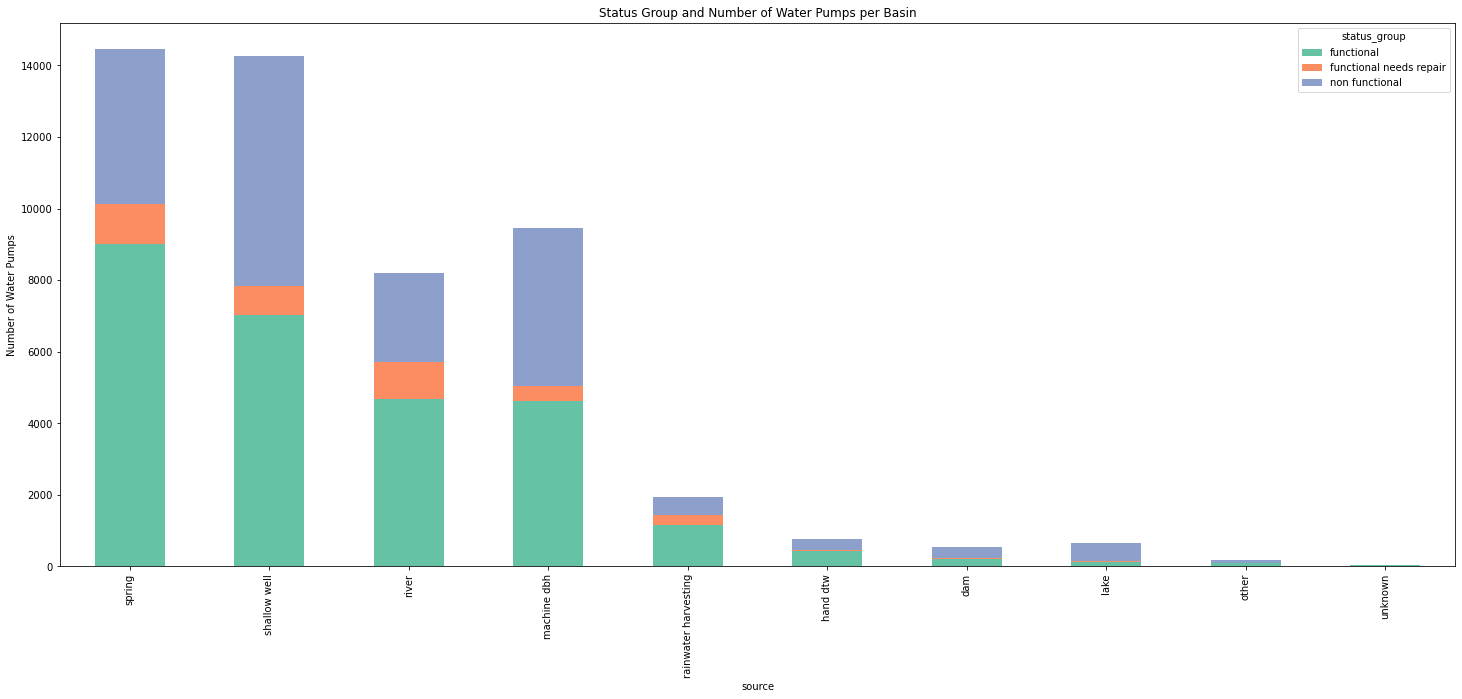

In [201]:
df_plot = train_data.groupby(['source', 'status_group']).size().reset_index().pivot(columns='status_group', index='source', values=0).sort_values('functional',ascending=False)
df_plot.plot(kind='bar', stacked=True, figsize=(25,10), title='Status Group and Number of Water Pumps per Basin', ylabel='Number of Water Pumps', color=my_cmap.colors);

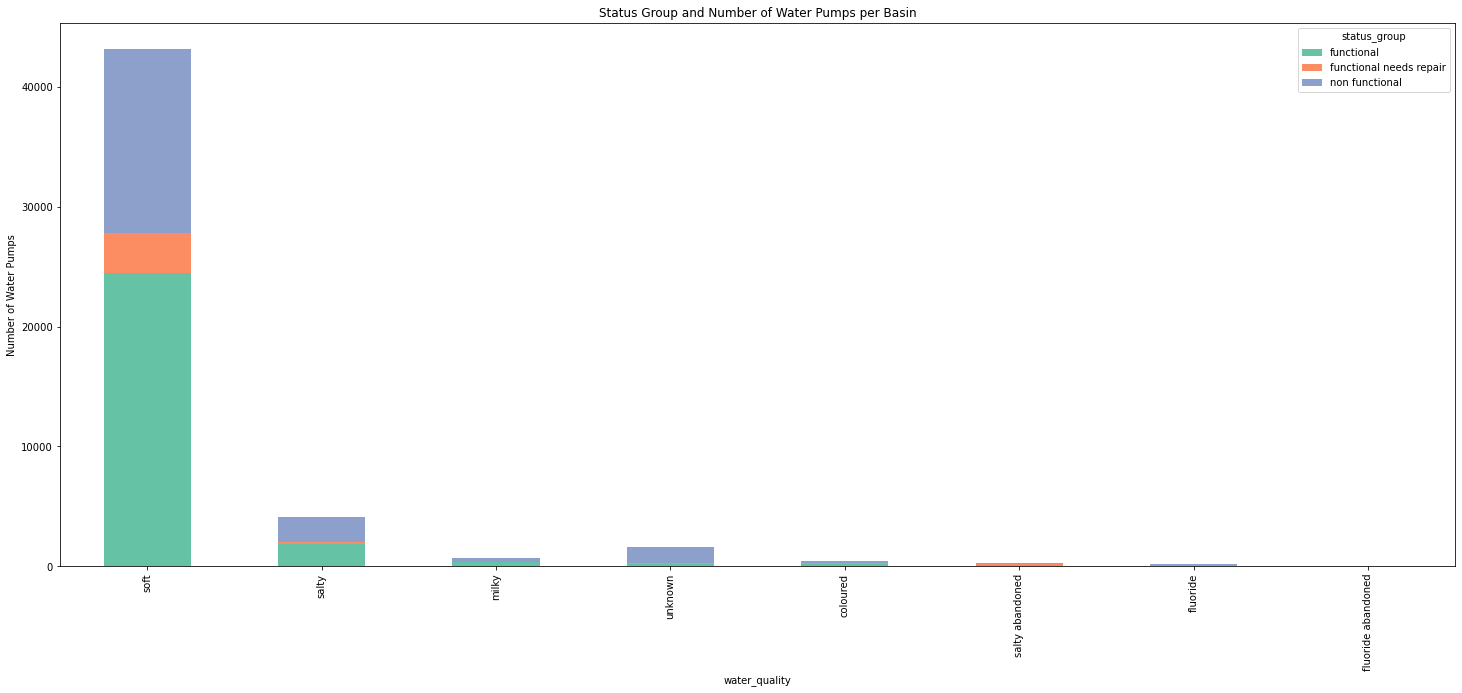

In [202]:
df_plot = train_data.groupby(['water_quality', 'status_group']).size().reset_index().pivot(columns='status_group', index='water_quality', values=0).sort_values('functional',ascending=False)
df_plot.plot(kind='bar', stacked=True, figsize=(25,10), title='Status Group and Number of Water Pumps per Basin', ylabel='Number of Water Pumps', color=my_cmap.colors);

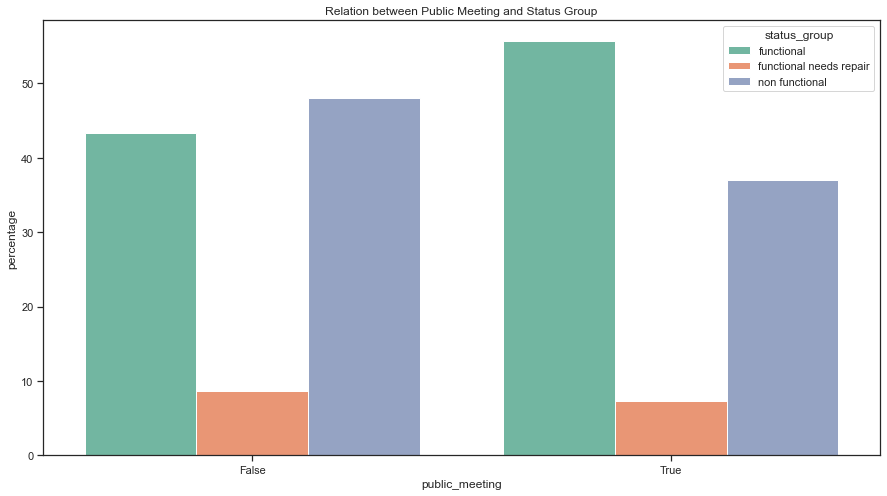

In [ ]:
plt.figure(figsize=(15,8))
attrition_counts = (train_data.groupby(['public_meeting'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status_group'))
plt.title('Relation between Public Meeting and Status Group')
sns.barplot(x="public_meeting", y="percentage", hue="status_group", data=attrition_counts, palette="Set2");

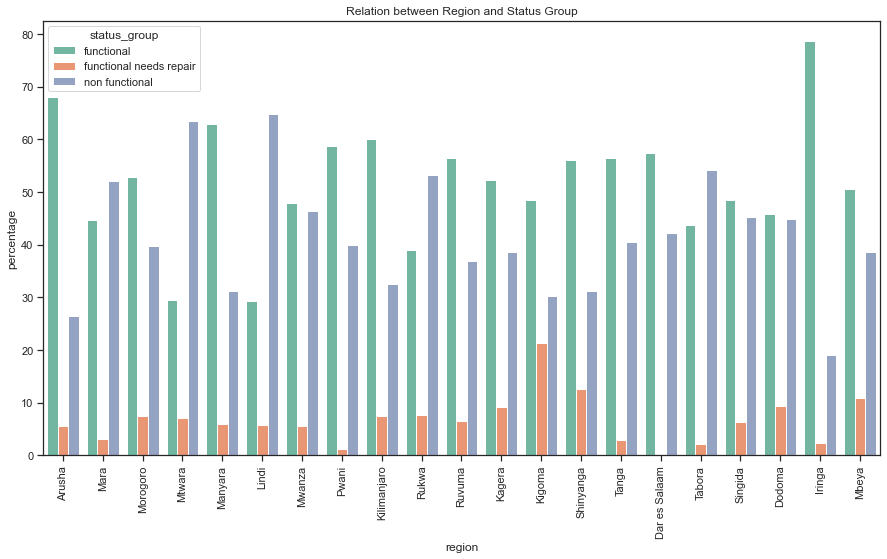

In [ ]:
plt.figure(figsize=(15,8))

attrition_counts = (train_data.groupby(['region'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status_group'))
plt.title('Relation between Region and Status Group')
plt.xticks(rotation=90)
sns.barplot(x="region", y="percentage", hue="status_group", data=attrition_counts, palette="Set2");

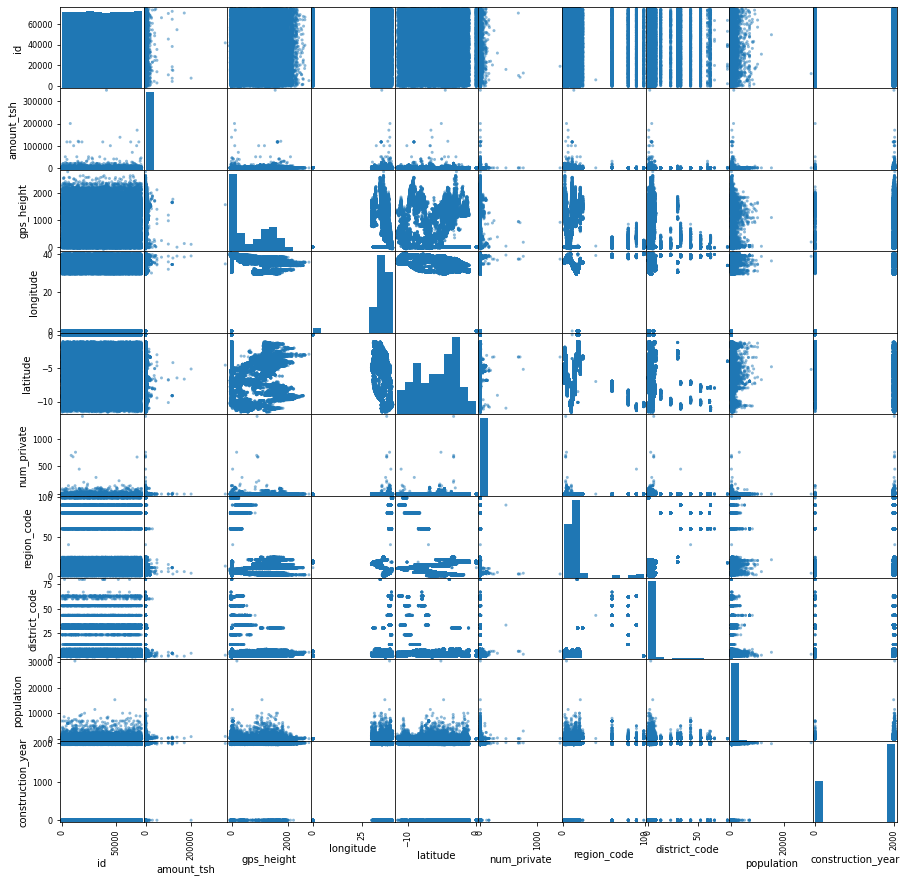

In [ ]:
pd.plotting.scatter_matrix(train_data, figsize=(15,15));

In [196]:
# function for plotting pie charts for each given category
colors = ['#66c2a5', '#fc8d62', '#8da0cb']
def plot_multiple_pie_by_category(df, category, n_max=None, n_cols=3):
    if n_max is None:
        categories = df[category].unique()
    else:
        categories = df[category].value_counts().index.tolist()[:n_max]
    
    n_rows = len(categories)
    fig = make_subplots(rows=len(categories)//n_cols, cols=n_cols, specs=[[{"type": "pie"}]*n_cols]*(len(categories)//n_cols))
    for i, label in enumerate(categories):
        df_label = df[df[category] == label]
        fig.add_trace(go.Pie(labels=df_label["status_group"].unique(), marker=dict(colors=colors),
        values=df_label["status_group"].value_counts(), 
        name=label, title=f"{label}: {len(df_label)} pumps"), row=i//n_cols+1, col=i%n_cols+1)
    fig.update_layout(height=max(900, n_rows*100), width=1800)
    fig.show()

In [197]:
plot_multiple_pie_by_category(train_data, "management", n_max=21)

>Die Brunnen werden von 12 unterschiedlichen Organisationen gemanaged. Vorreiter ist 'VWC' mit knapp 70%. Mit weitem Abstand folgt 'WUG' mit knapp über 10%. Die anderen 10 Organisationen pendeln sich im Bereich von unter 10% ein. Dies zeigt, dass 'VWC' eine sehr große Rolle in dieser Region spielt.

#### Abhängigkeit des Merkmals Funder zu Status_Group

In [ ]:
plot_multiple_pie_by_category(train_data, "funder", n_max=21)

>Mit Hilfe dieser Pie Charts ist es möglich einen schnellen und aufschlussreichen Überblick über die Abhängigkeit des Merkmals Funder zu 'status_group' zu erhalten.

#### Verteilung des Merkmals status_group bei Größe der Bevölkerung

In [ ]:
px.box(train_data, x="population", y="status_group")

>In diesem Boxplot ist die Verteilung der Werte sehr auffällig, da sich der Median bei 0 befindet. Dies lässt darauf schließen, dass es sehr viele Nullwerte gibt. Diese sollten im späteren Vorgehen näherer betrachtet werden.

c:\Users\Isabel\anaconda3\envs\University\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


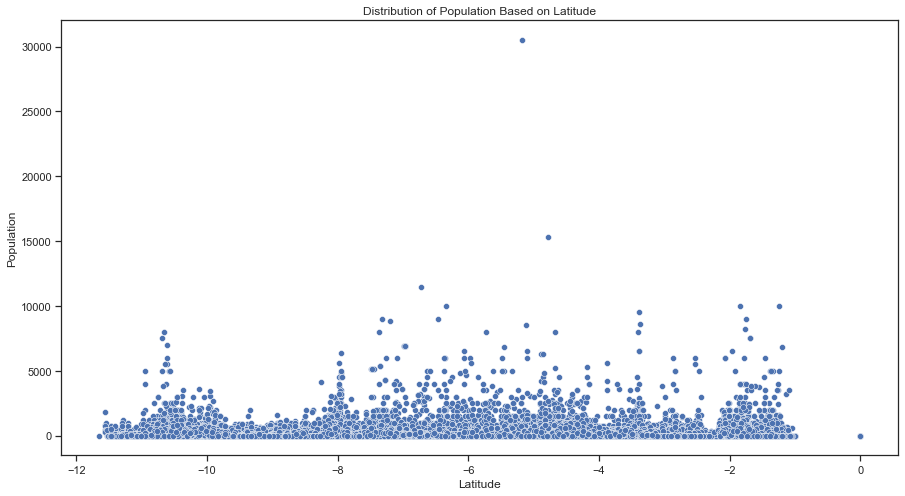

In [ ]:
fig = plt.figure(figsize=(15,8))  

sns.set(style="ticks", color_codes=True)
ax = sns.scatterplot(train_data['latitude'], train_data['population'])
ax.set(ylabel='Population', 
       xlabel='Latitude', 
       title='Distribution of Population Based on Latitude');

>Was soll damit ausgesagt werden?

c:\Users\Isabel\anaconda3\envs\University\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


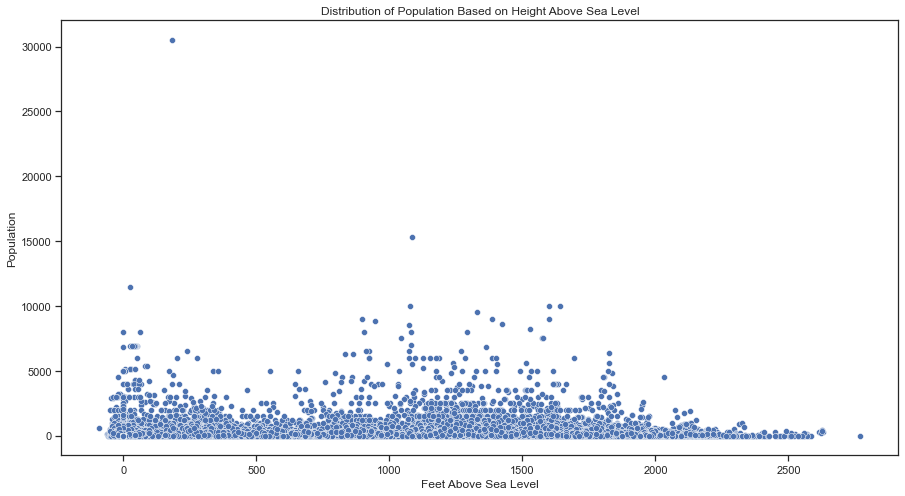

In [ ]:
# Scatter Plot of Population compared to Height above sea level.  
fig = plt.figure(figsize=(15,8))  

sns.set(style="ticks", color_codes=True)
ax = sns.scatterplot(train_data['gps_height'], train_data['population'])
ax.set(ylabel='Population', 
       xlabel='Feet Above Sea Level', 
       title='Distribution of Population Based on Height Above Sea Level');

#### Region

>Analysierte Spalten: gps_height, longitude, latitude, subvillage, region, region_code, district_code

In [223]:
fig = px.scatter_mapbox(train_data, lat="latitude", lon="longitude", color="status_group", opacity=0.7, mapbox_style="carto-positron")#,  scope="africa",
fig.show()

> Aus der Karte lässt sich ablesen, dass es sich hauptsächlich um Brunnen in dem afrikanischen Land Tansania handelt. Bei genauerer Betrachtung des Ausreißers wird klar, dass es sich hier um einen "Ausreißer" handelt, da in seiner Lattitude ein Buchstabe befindet.



>Code für farbige KArte??

In [ ]:
# Print the value counts for categorical columns
for col in train_data.columns:
    if train_data[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(train_data[col].value_counts())


Column Name: date_recorded
2011-03-15    490
2011-03-17    466
2013-02-03    463
2011-03-14    449
2011-03-16    440
             ... 
2011-09-16      1
2011-09-17      1
2011-09-18      1
2011-09-28      1
2004-04-05      1
Name: date_recorded, Length: 348, dtype: int64

Column Name: funder
Government Of Tanzania    7697
Danida                    2627
Hesawa                    1868
Rwssp                     1160
World Bank                1130
                          ... 
Jeshi Lawokovu               1
Timothy Shindika             1
Miab                         1
Mbwiro                       1
Dwarf                        1
Name: funder, Length: 1734, dtype: int64

Column Name: installer
DWE                   14799
Government             1534
RWE                    1015
Commu                   897
DANIDA                  883
                      ...  
WAMBA                     1
Mr Sau                    1
Q-sem Ltd                 1
ROMAN CATHOLIC            1
Emmanuel Kiswagala  

In [ ]:
# Create a new column to explore what variables in columns have more 
# functional or more broken and non functional pumps.

replace_values = {'functional':2, 'functional needs repair':1,
                   'non functional':0}

train_data['status_values']  = train_data.status_group.replace(replace_values)

In [ ]:
train_data.basin.value_counts()

Lake Victoria              8645
Pangani                    7622
Rufiji                     6751
Internal                   6629
Lake Tanganyika            5520
Wami / Ruvu                5078
Lake Nyasa                 4346
Ruvuma / Southern Coast    3802
Lake Rukwa                 2097
Name: basin, dtype: int64

In [ ]:
# See what basin area has the most functional and least functional pumps
piv_bas = pd.pivot_table(train_data, index=['basin', 'status_group'],
                           values=['status_values'], aggfunc='count')
piv_bas

status_values
basin                   status_group                          
Internal                functional                        3835
                        functional needs repair            478
                        non functional                    2316
Lake Nyasa              functional                        2856
                        functional needs repair            217
                        non functional                    1273
Lake Rukwa              functional                         862
                        functional needs repair            234
                        non functional                    1001
Lake Tanganyika         functional                        2668
                        functional needs repair            636
                        non functional                    2216
Lake Victoria           functional                        4295
                        functional needs repair            825
                        non functional                    3525
Pangani                 functional                        4558
                        functional needs repair            418
                        non functional                    2646
Rufiji                  functional                        4326
                        functional needs repair            368
                        non functional                    2057
Ruvuma / Southern Coast functional                        1397
                        functional needs repair            273
                        non functional                    2132
Wami / Ruvu             functional                        2639
                        functional needs repair            228
                        non functional                    2211

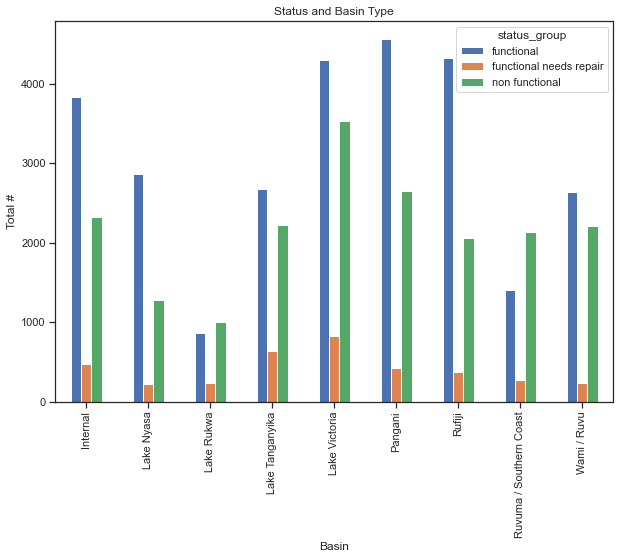

In [ ]:
# Examine the functionality of pumps in different basins.
train_data.groupby('basin')['status_group'].value_counts().unstack(level=1).plot.bar(figsize=(10,7)).set(ylabel='Total #', 
       xlabel='Basin', 
       title='Status and Basin Type');

In [ ]:
# See what payment types have the most functional and least functional pumps
piv_pay = pd.pivot_table(train_data, index= ['payment', 'status_group'],
                           values=['status_values'], aggfunc='count')
piv_pay

status_values
payment               status_group                          
never pay             functional                        9663
                      functional needs repair           1635
                      non functional                   10279
other                 functional                         524
                      functional needs repair            103
                      non functional                     285
pay annually          functional                        2337
                      functional needs repair            211
                      non functional                     544
pay monthly           functional                        4678
                      functional needs repair            778
                      non functional                    1583
pay per bucket        functional                        5163
                      functional needs repair            341
                      non functional                    2124
pay when scheme fails functional                        2060
                      functional needs repair            230
                      non functional                    1021
unknown               functional                        3011
                      functional needs repair            379
                      non functional                    3541

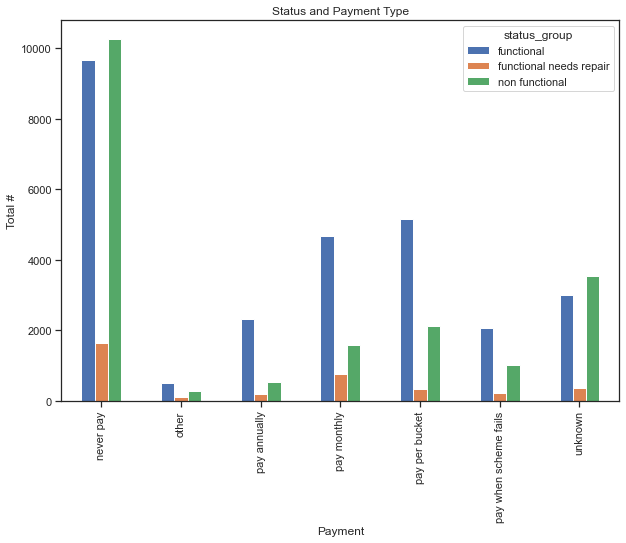

In [ ]:
# Examine the functionality of pumps based on payment type.
train_data.groupby('payment')['status_group']\
    .value_counts()\
    .unstack(level=1)\
    .plot.bar(figsize=(10,7))\
    .set(ylabel='Total #', 
       xlabel='Payment', 
       title='Status and Payment Type');

In [ ]:
piv_con = pd.pivot_table(train_data, index= ['construction_year', 'status_group'],
                           values=['status_values'], aggfunc='count')
piv_con

status_values
construction_year status_group                          
0                 functional                        8988
                  functional needs repair           1504
                  non functional                    7083
1960              functional                          22
                  functional needs repair              5
...                                                  ...
2012              functional needs repair             45
                  non functional                     257
2013              functional                          81
                  functional needs repair              1
                  non functional                      63

[164 rows x 1 columns]

> => es fällt auf, dass eine Jahreszahlen in construction_year auf Null gesetzt sind. Diese müssen anschließen in der Data Preparation bereinigt werden.

### Bewertung der Daten: 
An diesem Punkt wird die Qualität des Datenbestandes bewertet. Es soll festgestellt werden, ob die Datenmenge für die Analyse ausreichend und verwendbar ist, wobei besonders auf fehlende Attributwerte zu achten ist.
> Aus der vorangegangenen Analyse des Datensatzes im Rahmen des Data Understandings kann festgestellt werden, dass die Daten vor der weiteren Verarbeitung/ Verwendung im nächsten Schritt durch die Data Preparation bereinigt und aufbereitet werden müssen.

## Data Preperation

### Auswahl der Daten:
Die Auswahl der Daten für das Data Mining hängt stark von den Zielen ab, die man für das Data Mining-Projekt definiert. Hier spielen die Datenqualität und die technischen Gegebenheiten eine große Rolle. Es wird eine Selektion der Daten vorgenommen. Am Ende dieses Prozesses sollte sich deutlich zeigen, welche Datenmengen(-Sets) in die Analyse aufgenommen werden oder ausgeschlossen werden.
>Auswahl der Daten

>BEgründung warum die Daten rausgehen

In [ ]:
df = train_data
numerical_cols = [col for col in df.columns if type(df.loc[0, col]) in [np.int64, np.float64]]
for col in ["id", "region_code", "district_code", "gps_height", "num_private"]:
    numerical_cols.remove(col)

numerical_cols

['amount_tsh', 'longitude', 'latitude', 'population', 'construction_year']

In [ ]:
cat_cols = [col for col in df.columns if type(df.loc[0, col]) not in [np.int64, np.float64]]
for col in ["date_recorded", "funder", "installer", "wpt_name", "subvillage", "ward", "scheme_name", "status_group", "basin", "region", "lga", "recorded_by"]:
    cat_cols.remove(col)

cat_cols

['public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

### Bereinigung der Daten: 
Ohne eine Bereinigung der Daten ist ein erfolgreiches Data Mining-Projekt fraglich. Es gilt, eine saubere Datenmenge auszuwählen oder die Datenmenge muss bereinigt sein, um das gewünschte Ergebnis in der Modellierung zu erreichen.
Um die Daten in eine brauchbare Darstellungsform zu bringen, transformiert man die Daten. Die Transformation kodiert Daten und verändert deren Granularität durch Aggregation oder Disaggregation.
>Bei der folgenden Bereinigung werden die Nullwerte durch den Median bzw. dem Modus der jeweiligen Spalte ersetzt.

>Die Dataframes werden in Numpy Arrays konvertiert für die folgende Übergabe an die Modelle.


#### Bereinigung des Trainingsdatensatzes:

In [ ]:
ds = Dataset(encoder="onehot", normalizer="standard")
# continous variables
for var in numerical_cols:
    df[var] = df[var].fillna(df[var].mean())
    vals = ds.normalize(df, var, mode="train")
    ds.add_feature(vals, var)

In [ ]:
# encodings
top_n = 30
for var in cat_cols:
    df[var] = df[var].fillna(df[var].mode())
    vals = ds.encode(df, var, mode="train", top_n=top_n)
    ds.add_feature(vals, var)

In [ ]:
label_arr = LabelEncoder().fit_transform(df["status_group"]).reshape(-1, 1)

ds.add_label(label_arr)

In [ ]:
X, y, names = ds.get_X(), ds.get_y(), ds.get_feature_names()

#### Bereinigung des Testdatensatzes:

In [ ]:
ds.reset_for_test()

In [ ]:
# continous variables
for var in numerical_cols:
    test_data[var] = test_data[var].fillna(df[var].mean())
    vals = ds.normalize(test_data, var, mode="test")
    ds.add_feature(vals, var)

In [ ]:
# encodings
top_n = 30
for var in cat_cols:
    test_data[var] = test_data[var].fillna(df[var].mode())
    vals = ds.encode(test_data, var, mode="test", top_n=top_n)
    ds.add_feature(vals, var)

In [ ]:
label_arr = LabelEncoder().fit_transform(test_data["status_group"]).reshape(-1, 1)

ds.add_label(label_arr)

In [ ]:
X_test, y_test, names_test = ds.get_X(), ds.get_y(), ds.get_feature_names()

## Modeling

### Auswahl der Modellierungstechnik: 
Hier gilt es eine Modellierungstechnik auswählen, mit der man das Modell erstellt
>Für die Modellauswahl werden 12 unterschiedliche Modelle betrachtet. Dabei werden drei Dummy Modelle erstellt (AllOnes, AllZeros, Random).

In [ ]:
class RandomPredictor:
    def __init__(self):
        self.__class__.__name__ = "----RANDOM----"
    def fit(self, X, y):
        return self
    def predict(self, X):
        return np.random.randint(0, 2, len(X))

    def predict_proba(self, X):
        return np.array([1/3, 1/3, 1/3]*len(X)).reshape(-1, 3)

class AllZeros:
    def __init__(self):
        self.__class__.__name__ = "----ALL 0's----"
    def fit(self, X, y):
        return self
    def predict(self, X):
        return np.zeros(X.shape[0])

    def predict_proba(self, X):
        return np.array([1, 0, 0]*len(X)).reshape(-1, 3)

class AllOnes:
    def __init__(self):
        self.__class__.__name__ = "----ALL 1's----"
    def fit(self, X, y):
        return self
    def predict(self, X):
        return np.ones(X.shape[0])
    def predict_proba(self, X):
        return np.array([0, 1, 0]*len(X)).reshape(-1, 3)

In [ ]:
models = [
    RandomPredictor(),
    AllZeros(),
    AllOnes(),
    DecisionTreeClassifier(), 
    GaussianNB(), 
    LogisticRegression(max_iter=300), 
    # Perceptron(max_iter=100), 
    SVC(max_iter=300, probability=True), 
    RandomForestClassifier(), 
    KNeighborsClassifier(), 
    SGDClassifier(loss="modified_huber"), 
    # XGBClassifier()
]

In [ ]:
scores_multi_class = {
    "model_name": [],
    "f1_score": [],
    "precision": [],
    "recall": [],
    "accuracy": [],
    "roc_auc": []
}

scores_not_functional = {
    "model_name": [],
    "f1_score": [],
    "precision": [],
    "recall": [],
    "accuracy": [],
    "roc_auc": []
}

scores_needs_repair = {
    "model_name": [],
    "f1_score": [],
    "precision": [],
    "recall": [],
    "accuracy": [],
    "roc_auc": []
}

mask_train_not_functional = y!=1
mask_test_not_functional = y_test!=1

mask_train_needs_repair = y!=2
mask_test_needs_repair = y_test!=2

l = [
    (..., ..., scores_multi_class),
    (mask_train_not_functional, mask_test_not_functional, scores_not_functional),
    (mask_train_needs_repair, mask_test_needs_repair, scores_needs_repair)
]

In [ ]:
metrics = [
    ("f1_score", lambda y_true, y_pred, y_prob: f1_score(one_vs_all(y_true), one_vs_all(y_pred))),
    ("precision", lambda y_true, y_pred, y_prob: precision_score(one_vs_all(y_true), one_vs_all(y_pred), zero_division=0)),
    ("recall", lambda y_true, y_pred, y_prob: recall_score(one_vs_all(y_true), one_vs_all(y_pred), zero_division=0)),
    ("accuracy", lambda y_true, y_pred, y_prob: accuracy_score(one_vs_all(y_true), one_vs_all(y_pred))),
    ("roc_auc", lambda y_true, y_pred, y_prob: roc_auc_score(one_vs_all(y_true), y_prob))
]

In [ ]:
for model, (train_mask, test_mask, scores) in tqdm(product(models, l), total=len(models)*len(l)):
    model = model.fit(X[train_mask], y[train_mask])
    y_prob, y_pred = get_prob_and_pred(model, X_test[test_mask])
    scores["model_name"] += [model.__class__.__name__]
    for name, function in metrics:
        scores[name] += [function(y_test[test_mask], y_pred, y_prob)]

 50%|█████     | 15/30 [00:16<00:18,  1.23s/it]c:\Users\Isabel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

 57%|█████▋    | 17/30 [00:51<01:50,  8.46s/it]c:\Users\Isabel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

In [ ]:
df = pd.DataFrame(data=scores_not_functional).sort_values("roc_auc", ascending=False)
df

model_name  f1_score  precision    recall  accuracy   roc_auc
7  RandomForestClassifier  0.813035   0.842777  0.785321  0.849456  0.918805
8    KNeighborsClassifier  0.786213   0.824785  0.751088  0.829746  0.886998
5      LogisticRegression  0.695361   0.822504  0.602263  0.780048  0.835459
9           SGDClassifier  0.687819   0.793627  0.606905  0.770375  0.823726
3  DecisionTreeClassifier  0.793831   0.796264  0.791413  0.828658  0.823192
4              GaussianNB  0.666996   0.770928  0.587757  0.755381  0.798572
6                     SVC  0.175059   0.463263  0.107920  0.576058  0.550748
0          ----RANDOM----  0.588376   0.416808  1.000000  0.416808  0.500000
1         ----ALL 0's----  0.000000   0.000000  0.000000  0.583192  0.500000
2         ----ALL 1's----  0.588376   0.416808  1.000000  0.416808  0.500000

>Interpretation von f1, precision....
>Auswahl des besten Modells + Begründung

In [ ]:
df = pd.DataFrame(data=scores_needs_repair).sort_values("roc_auc", ascending=False)
df

model_name  f1_score  precision    recall  accuracy   roc_auc
7  RandomForestClassifier  0.499069   0.617512  0.418750  0.901519  0.859460
8    KNeighborsClassifier  0.471910   0.588785  0.393750  0.896760  0.806832
5      LogisticRegression  0.093159   0.680851  0.050000  0.885960  0.749046
3  DecisionTreeClassifier  0.437742   0.433384  0.442188  0.866923  0.696367
9           SGDClassifier  0.003101   0.200000  0.001563  0.882299  0.684454
4              GaussianNB  0.228822   0.130284  0.939063  0.258466  0.569888
6                     SVC  0.000000   0.000000  0.000000  0.882848  0.565648
0          ----RANDOM----  0.209733   0.117152  1.000000  0.117152  0.500000
1         ----ALL 0's----  0.000000   0.000000  0.000000  0.882848  0.500000
2         ----ALL 1's----  0.209733   0.117152  1.000000  0.117152  0.500000

>Interpretation von f1, precision....
>Auswahl des besten Modells + Begründung

In [ ]:
df = pd.DataFrame(data=scores_multi_class).sort_values("roc_auc", ascending=False)
df

model_name  f1_score  precision    recall  accuracy   roc_auc
7  RandomForestClassifier  0.795597   0.813924  0.778077  0.816611  0.892411
8    KNeighborsClassifier  0.774308   0.804537  0.746269  0.800449  0.863806
5      LogisticRegression  0.679617   0.800133  0.590653  0.744557  0.807578
9           SGDClassifier  0.674745   0.771654  0.599462  0.734905  0.793294
3  DecisionTreeClassifier  0.765786   0.765973  0.765598  0.785185  0.785336
4              GaussianNB  0.631984   0.475059  0.943724  0.495847  0.558718
6                     SVC  0.241872   0.448048  0.165647  0.523681  0.540124
0          ----RANDOM----  0.628914   0.458698  1.000000  0.458698  0.500000
1         ----ALL 0's----  0.000000   0.000000  0.000000  0.541302  0.500000
2         ----ALL 1's----  0.628914   0.458698  1.000000  0.458698  0.500000

>Interpretation von f1, precision....
>Auswahl des besten Modells + Begründung

### Testmodell erstellen: 
Nach Auswahl des Modells wird ein Testmodell erstellt, um Qualität und Genauigkeit des Modells zu überprüfen. In überwachten Verfahren, wie der Klassifikation, ist es üblich, die Fehlerraten als Qualitätsmaß zu nutzen.
>Aus den vorangegangenen Analysen geht hervor, dass der RandomForestClassifier bei allen drei Modellen, die beste Performance aufzeigt. Daher wird dieses Modell im folgenden weiter optimiert um die bestmöglichen Resultate zu erzielen.

In [ ]:
param_grid = {
    'n_estimators': [40, 100, 200, 500],
    # 'max_depth': [50, 100, None],
    # 'max_features': [None, 'sqrt'],
    'max_samples': [0.8, 1.0]
}
gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=3, verbose=1)

In [ ]:
gs.fit(X, y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\Isabel\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Isabel\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Isabel\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 343, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "c:\Users\Isabel\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 110, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0


c:\Users\Isabel\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_samples': [0.8, 1.0],
                         'n_estimators': [40, 100, 200, 500]},
             verbose=1)

In [ ]:
df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

In [ ]:
df[["param_max_samples", "param_n_estimators", "mean_test_score", "mean_fit_time"]]

param_max_samples param_n_estimators  mean_test_score  mean_fit_time
3               0.8                500         0.794435      90.382313
1               0.8                100         0.792692      19.189634
2               0.8                200         0.792672      35.932351
0               0.8                 40         0.790869       7.362815
4               1.0                 40              NaN       0.112950
5               1.0                100              NaN       0.161121
6               1.0                200              NaN       0.153843
7               1.0                500              NaN       0.109753

In [ ]:
model = gs.best_estimator_.fit(X, y)

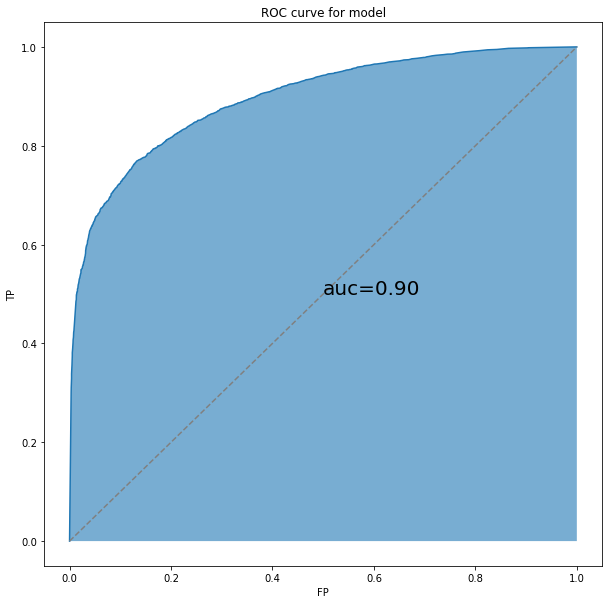

In [ ]:
plot_roc(model, X_test, y_test, model_name="model")

## Evaluation

### Bewertung des Modells: 
Hier ist das Modell nach der im Vorfeld definierten Data Mining-Zielsetzung zu bewerten. Des Weiteren gilt es die Data Mining-Ergebnisse in Bezug auf die Fragestellung zu bewerten.
>AUC Modell 1

>AUC Modell 2

>AUC Modell 3

### Bewerten der Resultate: 
In diesem Schritt bewertet man, inwieweit das Modell die Projektziele erreicht. Wenn die Ziele nicht erreicht sind, ist aufzuführen, aus welchen Gründen.
>Begründung warum das Modell eingesetzt werden sollte, positiver Effekt....

### Bewertung des Prozesses: 
Das Data Mining-Projekt wird rückblickend bewertet. Es wird festgestellt, ob alle wichtigen Faktoren betrachtet wurden und inwieweit die Attribute für zukünftige Data Mining-Projekte zu nutzen sind.
>Auffälligkeiten bei den Daten, Modellen, Ergebnissen

>Zusammenarbeit

## Deployment

Die Deployment-Phase bildet in der Regel die Endphase eines Data Mining-Projektes. Hier werden die gewonnenen Erkenntnisse so geordnet und präsentiert, sodass für den Auftraggeber die Möglichkeit besteht dieses Wissen zu nutzen. Dazu gehört eine eventuelle Implementierungsstrategie, die Überwachung der Gültigkeit der Modelle, ein zusammenfassender Bericht und eine Präsentation.
>Fazit



In [ ]:
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions }) # kopiert aus NB1
output.to_csv('submission.csv', index=False)

pd.read_csv("submission.csv")

Quellen:
<ul>
    <li>Quelle: https://datasolut.com/crisp-dm-standard/amp/</li>
</ul>